以下是Protein Kinetic Extraction结果进行Data Analysis的一系列分析代码

导入所需的包

In [113]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

Part 1 - Brenda数据有误差
1.1. 用Venn Diagram展示36篇random_samples上，Brenda数据和Golden数据，基于kcat/km字段line-by-line对齐后，overlap的数据行情况，面积大小直接展示行数多少（line-by-line对齐数据见data/others/20241025_brenda_golden_36_merge.xlsx），这种情况的数值展示在接下来的代码块中

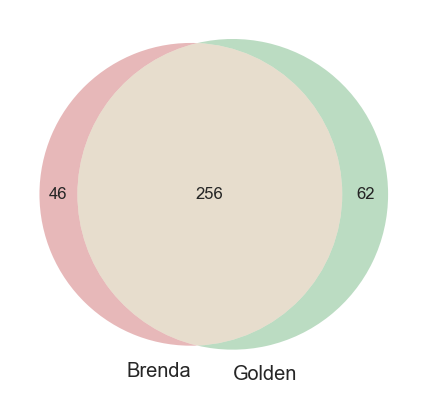

In [118]:
# 输入数据
Brenda_only = 46  # 换成对应的值
Golden_only = 256  # 换成对应的值
BG_common = 62  # 换成对应的值

# Venn Diagram
venn_labels = (Brenda_only, BG_common, Golden_only)
venn2(subsets=venn_labels, set_labels=('Brenda', 'Golden'))

plt.show()

1.2. 除了line-by-line对齐外的overlapping的情况，如总数或者分字段数据的overlapping情况，相当于将brenda数据作为一个模型，在金标准上进行测评，如果需要相应地汇报，可以根据brenda模型测评结果改动数值得到相应的图

Part 2 - 基于 expert-annotated dataset，我们ablate 其中若干关键的 design choice，比如 input format, 大语言模型，和大语言模型的超参数等

2.0. 按文件名排序处理指定文件夹中的所有 JSON 文件, 返回 F1 结果的 DataFrame, 对接后面的画图

In [119]:
def calculate_f1_from_json(json_path):
    """
    从 JSON 文件中计算 F1-score，并返回结果 DataFrame
    """
    # 读取JSON文件
    json_data = pd.read_json(json_path)

    # 将JSON数据转换为字典
    data_dict = json_data.to_dict(orient='index')

    # 不看后面total的统计部分
    filtered_data = {k: v for k, v in data_dict.items() if k != "total"}

    # 转换为转置的DataFrame
    df = pd.DataFrame.from_dict(filtered_data, orient='index').transpose()

    # 不需要最后total的这行数据，只需要前面paper-wise的数据
    df = df.drop(index='total')

    # index命名为pubmedid
    df.index.name = 'pubmedid'

    # 计算各篇上的recall值
    df['recall'] = df['total_right_num'] / (df['total_golden'] + 1e-10)

    # 计算各篇上的precision值
    df['precis'] = df['total_right_num'] / (df['total_big_model'] + 1e-10)

    # 计算 F1-score
    df['F1'] = 2 * df['recall'] * df['precis'] / (df['recall'] + df['precis'] + 1e-10)

    return df[['precis', 'recall', 'F1']].reset_index()


def process_all_json_in_folder(folder_path):
    """
    按文件名排序处理指定文件夹中的所有 JSON 文件并返回 F1 结果的 DataFrame
    """
    f1_results = pd.DataFrame()

    # 获取并排序文件夹中的所有 JSON 文件
    json_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.json')])

    # 每个文件计算F1-score后存入f1_results
    for filename in json_files:
        json_path = os.path.join(folder_path, filename)
        f1_df = calculate_f1_from_json(json_path)
        f1_df['file'] = filename[:-5]  # 去掉".json的字样，直接用文件名"
        f1_results = pd.concat([f1_results, f1_df], ignore_index=True)

    return f1_results

2.0. 基于F1-score数据进行swarmplot + violinplot的画图代码

In [173]:
def plot_f1_swarm(f1_results, title=None, xlabel=None, ylabel=None, category_order=None):
    """
    基于F1-score数据进行swarmplot + violinplot
    参数：
    f1_results (DataFrame): 包含 'F1' 和 'file' 列的 DataFrame
    """
    # 将 'file' 列转换为类别型，以便绘图时可以分组
    f1_results['file'] = pd.Categorical(f1_results['file'], categories=category_order, ordered=True)
    num_categories = len(f1_results['file'].cat.categories)

    # 设置样式
    sns.set(style="ticks")

    # 创建图形
    fig = plt.figure(figsize=(num_categories * 1.2, 4.5))

    # 调整边距
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

    # violin plot
    sns.violinplot(x='file', y='F1', data=f1_results, hue='file', legend=False,
                   palette='Set2', bw_adjust=.3, alpha=0.5,
                   inner_kws=dict(box_width=6, whis_width=2), zorder=2)

    # swarm plot
    sns.swarmplot(x='file', y='F1', data=f1_results, hue='file', legend=False,
                  palette='Set2', size=4, zorder=1)

    # 中位数点
    sns.pointplot(
        x='file', y='F1', data=f1_results, hue='file', legend=False,
        dodge=False, linestyle="none", errorbar=None, estimator=np.median,
        marker="_", markersize=20, markeredgewidth=3,
        palette=['black'] * num_categories, zorder=3
    )

    # 均值点
    sns.pointplot(
        x='file', y='F1', data=f1_results, hue='file', legend=False,
        dodge=False, linestyle="none", errorbar=None, estimator=np.mean,
        marker="_", markersize=20, markeredgewidth=3,
        palette=['white'] * num_categories, zorder=4
    )

    # title和label及字体
    plt.xlabel(xlabel, fontsize=12)
    plt.title(title, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)

    # 刻设置度标签的字体大小
    plt.gca().tick_params(axis='both', labelsize=12)

    # box和框线
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(True)
    plt.gca().spines['bottom'].set_visible(True)

    # 显示图
    # plt.tight_layout()
    plt.show()

    return fig

2.1. 绘制不同的温度条件下，Claude模型的F1表现的swarmplot + violinplot分布

/opt/anaconda3/envs/kineticAnalyze/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 47.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/kineticAnalyze/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 48.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/kineticAnalyze/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 48.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/kineticAnalyze/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 49.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/kine

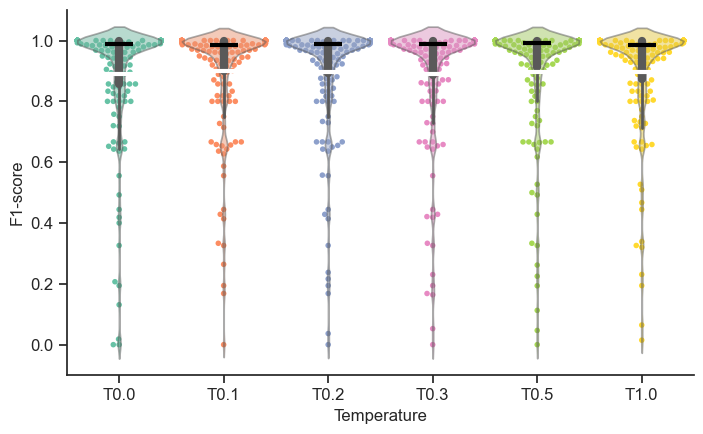

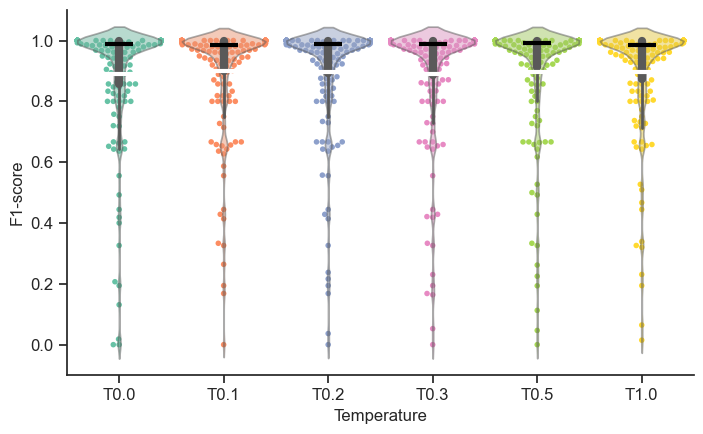

In [170]:
folder_path = 'data/params_temper_data_claude/'
f1_results = process_all_json_in_folder(folder_path)
plot_f1_swarm(f1_results, xlabel='Temperature', ylabel='F1-score')

2.2. 绘制不同的Input Format条件下，Claude模型的F1表现的swarmplot + violinplot分布

/opt/anaconda3/envs/kineticAnalyze/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 42.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/kineticAnalyze/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 51.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/kineticAnalyze/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 42.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/kineticAnalyze/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 51.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


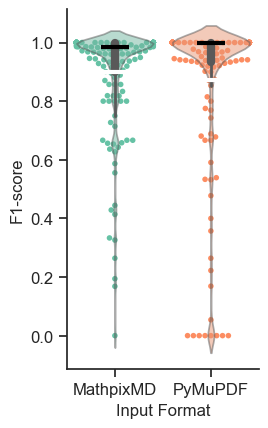

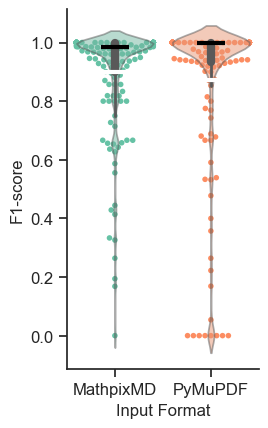

In [174]:
folder_path = 'data/params_ocr_data/'
f1_results = process_all_json_in_folder(folder_path)
plot_f1_swarm(f1_results, xlabel='Input Format', ylabel='F1-score')

2.3. 绘制不同的温度条件下，Claude模型和GPT-4o模型的F1表现的折线图plot

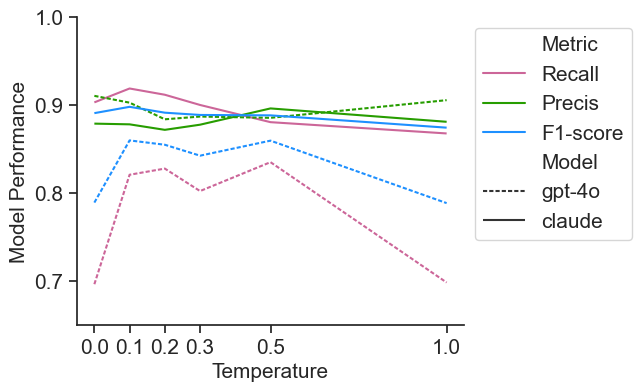

In [202]:
# GPT-4o和Claude这两个模型的，不同温度的结果文件，存储在两个不同的文件夹中
folder_paths = ['data/params_temper_data_gpt-4o/', 'data/params_temper_data_claude/']

data = []

# 获取并排序文件夹中的所有 JSON 文件
for folder_path in folder_paths:
    json_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.json')])

    # 每个文件计算总体F1-score后存入data
    for filename in json_files:
        json_path = os.path.join(folder_path, filename)

        # 读取JSON文件
        json_data = pd.read_json(json_path)

        # 提取数据
        total_golden = json_data['total']['total_golden']
        total_big_model = json_data['total']['total_big_model']
        total_right_num = json_data['total']['total_right_num']

        # 计算存入data
        recall = total_right_num / (total_golden + 1e-10)
        precis = total_right_num / (total_big_model + 1e-10)
        F1 = 2 * recall * precis / (recall + precis + 1e-10)

        # 提取模型信息
        model_name = folder_path.split('_')[-1].strip('/')

        # 提取温度信息
        temper = float(filename[1:-5])

        data.append({'Temperature': temper, 'Recall': recall, 'Precis': precis, 'F1-score': F1,
                     'Model': model_name})

# 将数据整理到 DataFrame
df_data = pd.DataFrame(data)

# 将数据转化为长格式，便于绘图
df_melted = df_data.melt(id_vars=['Temperature', 'Model'], value_vars=['Recall', 'Precis', 'F1-score'],
                         var_name='Metric', value_name='Value')

# 绘制折线图
fig = plt.figure(figsize=(5, 4))
colors = ['#CC6699', '#279D00', '#1E90FF']
sns.lineplot(data=df_melted, x='Temperature', y='Value', hue='Metric', style='Model', palette=colors,
             markers=False, dashes={'claude': (1, 0), 'gpt-4o': (2, 1)})

# lims and ticks
plt.ylim(0.65, 1.00)
plt.yticks([0.7, 0.8, 0.9, 1.0], fontsize=15)
x_values = sorted(df_data['Temperature'].unique())
plt.xticks(x_values, [str(x) for x in x_values], fontsize=15)


# Labels and legends
plt.xlabel('Temperature', fontsize=15)
plt.ylabel('Model Performance', fontsize=15)

plt.legend(title=None, fontsize=15, loc='upper left', bbox_to_anchor=(1, 1))  # 将图例放在右侧

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# box和框线
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# 显示图
plt.show()

# 存储图
fig.savefig('figure/fig.2d.svg', format='svg', bbox_inches='tight')
fig.savefig('figure/fig.2d.png', format='png', dpi=300, bbox_inches='tight')

Part 3 - 我们设计了 aggregation agent 模块来合并不同数据

3.1. 绘制Brenda模型的表现，F1的swarmplot + violinplot分布

/var/folders/gh/dlx7b8px6xv9d7n3t9flwqmc0000gn/T/ipykernel_1672/2312490994.py:6: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  json_data = pd.read_json(json_path)
/var/folders/gh/dlx7b8px6xv9d7n3t9flwqmc0000gn/T/ipykernel_1672/2312490994.py:6: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  json_data = pd.read_json(json_path)
/var/folders/gh/dlx7b8px6xv9d7n3t9flwqmc0000gn/T/ipykernel_1672/2312490994.py:6: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings i

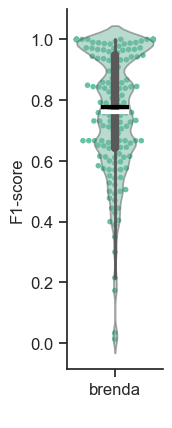

In [179]:
folder_path = 'data/brenda_data/'
f1_results = process_all_json_in_folder(folder_path)
fig = plot_f1_swarm(f1_results, xlabel=" ", ylabel='F1-score')
# 存储图
fig.savefig('figure/fig.2a.svg', format='svg', bbox_inches='tight')
fig.savefig('figure/fig.2a.png', format='png', dpi=300, bbox_inches='tight')

3.2. 绘制4个模型的表现，F1的swarmplot + violinplot分布

/opt/anaconda3/envs/kineticAnalyze/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 28.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/kineticAnalyze/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 34.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/kineticAnalyze/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 38.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/kineticAnalyze/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 44.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/kine

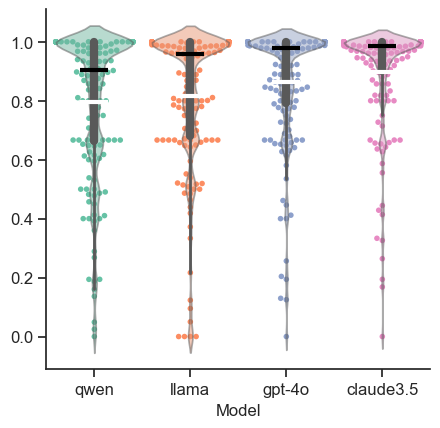

In [180]:
folder_path = 'data/llm_4_data/'
f1_results = process_all_json_in_folder(folder_path)
fig = plot_f1_swarm(f1_results, xlabel='Model', ylabel=None, category_order=['qwen', 'llama','gpt-4o','claude3.5'])
# 存储图
fig.savefig('figure/fig.2b.svg', format='svg', bbox_inches='tight')
fig.savefig('figure/fig.2b.png', format='png', dpi=300, bbox_inches='tight')

3.3. 绘制综合4模型aggregation agent的表现，F1的swarmplot + violinplot分布

/opt/anaconda3/envs/kineticAnalyze/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 48.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/kineticAnalyze/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 50.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


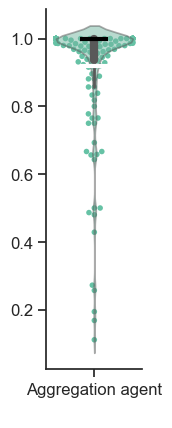

/opt/anaconda3/envs/kineticAnalyze/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 51.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


In [181]:
folder_path = 'data/aggregation_data_protein_enzyme/'
f1_results = process_all_json_in_folder(folder_path)
fig = plot_f1_swarm(f1_results, xlabel=" ", ylabel=None)
# 存储图
fig.savefig('figure/fig.2c.svg', format='svg', bbox_inches='tight')
fig.savefig('figure/fig.2c.png', format='png', dpi=300, bbox_inches='tight')

3.4. 绘制ribozyme不同的模型和aggregation模型的表现，F1的swarmplot + violinplot分布

/opt/anaconda3/envs/kineticAnalyze/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 12.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/kineticAnalyze/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 18.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/kineticAnalyze/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 35.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/kineticAnalyze/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 32.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/kine

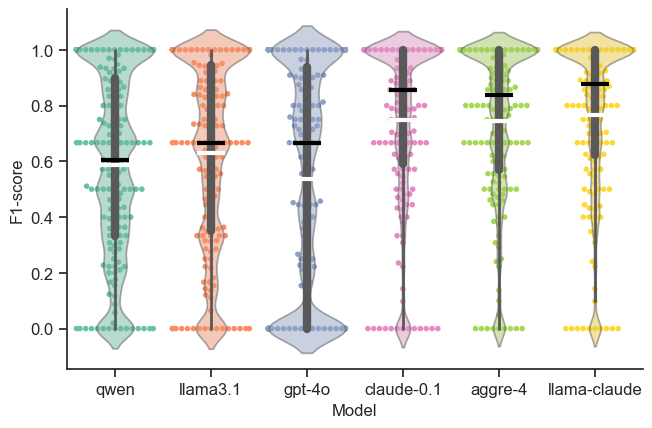

In [182]:
folder_path = 'data/aggregation_data_ribozyme/'
f1_results = process_all_json_in_folder(folder_path)
fig = plot_f1_swarm(f1_results, xlabel='Model', ylabel='F1-score', category_order=['qwen', 'llama3.1','gpt-4o','claude-0.1','aggre-4','llama-claude'])
# 存储图
fig.savefig('figure/fig.4a.svg', format='svg', bbox_inches='tight')
fig.savefig('figure/fig.4a.png', format='png', dpi=300, bbox_inches='tight')

Part 4 - 最终 expert-annotated dataset 上的表现 和 entire dataset 上的表现

4.0. 基于single model的 JSON 文件数据，paper-wise的recall和precision为横纵坐标进行scatter plot画图代码

In [128]:
def plot_joint_distribution(json_path, right_field, golden_field, big_model_field, color="#B6D0AF"):
    """
    基于single model的JSON文件数据，计算paper wise的recall和precision，为横纵坐标进行scatter plot
    点的大小表示Extracted Entries，点的颜色表示Benchmark Entries
    参数：
    right_field : 表示准确结果的字段名，可以是'total_right_num'，也可是分字段的'km_right_num'等，注意匹配
    golden_field : 表示金标准结果的字段名，可以是'total_golden'，也可是分字段的'km_golden'等，注意匹配
    big_model_field : 表示抽取结果的字段名，可以是'total_big_model'，也可是分字段的'km_big_model'等，注意匹配
    """

    # 读取 JSON 文件
    json_data = pd.read_json(json_path)

    # 将 JSON 数据转换为字典
    data_dict = json_data.to_dict(orient='index')

    # 不看后面total的统计部分
    filtered_data = {k: v for k, v in data_dict.items() if k != "total"}

    # 转换为转置的DataFrame
    data = pd.DataFrame.from_dict(filtered_data, orient='index').transpose()

    # 不需要最后total的这行数据，只需要前面paper-wise的数据
    data = data.drop(index='total')

    # index命名为pubmedid
    data.index.name = 'pubmedid'

    # 计算值
    data['x_data'] = data[right_field] / (data[golden_field] + 1e-10) * 100
    data['y_data'] = data[right_field] / (data[big_model_field] + 1e-10) * 100
    data['Benchmark Entries'] = data["total_golden"]
    data['Extracted Entries'] = data["total_big_model"]

    # 创建 JointGrid
    sns.set_theme(style="ticks")

    cmap = sns.cubehelix_palette(rot=-.5, as_cmap=True)
    g = sns.JointGrid(data=data, x="x_data", y="y_data", space=0.5, ratio=5)
    g.plot_joint(sns.scatterplot, size=data["Extracted Entries"], sizes=(10, 500),
                 hue=data["Benchmark Entries"], alpha=.6, legend=True, palette=cmap)

    # 调整图例字体大小
    handles, labels = g.ax_joint.get_legend_handles_labels()
    g.ax_joint.legend(handles, labels, fontsize=9)

    # 添加边际分布（直方图）
    sns.histplot(x=data['x_data'], color=color, bins=20, ax=g.ax_marg_x, alpha=1, kde=False, edgecolor=color)
    sns.histplot(y=data['y_data'], color=color, bins=20, ax=g.ax_marg_y, alpha=1, kde=False, edgecolor=color)

    # 设置坐标轴的标签和标题
    g.set_axis_labels('Recall (%)', 'Precision (%)', fontsize=15)

    # 设置刻度标签的字体大小
    g.ax_joint.tick_params(axis='both', labelsize=15)

    # 设置坐标轴粗细
    spine_width = 1  # 可以自定义坐标轴的宽度
    g.ax_joint.spines['top'].set_visible(False)
    g.ax_joint.spines['right'].set_visible(False)
    g.ax_joint.spines['left'].set_linewidth(spine_width)
    g.ax_joint.spines['bottom'].set_linewidth(spine_width)

    # 设置刻度线的长度和宽度
    tick_length = 5  # 刻度线的长度
    tick_width = 1  # 刻度线的宽度

    g.ax_joint.tick_params(axis='both', which='major', length=tick_length, width=tick_width)
    g.ax_joint.tick_params(axis='both', which='minor', length=tick_length / 2, width=tick_width)

    # 边际坐标轴刻度设置
    g.ax_marg_x.tick_params(axis='both', which='major', length=tick_length, width=tick_width)
    g.ax_marg_x.tick_params(axis='both', which='minor', length=tick_length / 2, width=tick_width)
    g.ax_marg_y.tick_params(axis='both', which='major', length=tick_length, width=tick_width)
    g.ax_marg_y.tick_params(axis='both', which='minor', length=tick_length / 2, width=tick_width)

    # 调整图形的边距
    plt.tight_layout()

    # 显示图
    plt.show()

4.1. Aggregation模型在expert-annotated dataset 上的表现

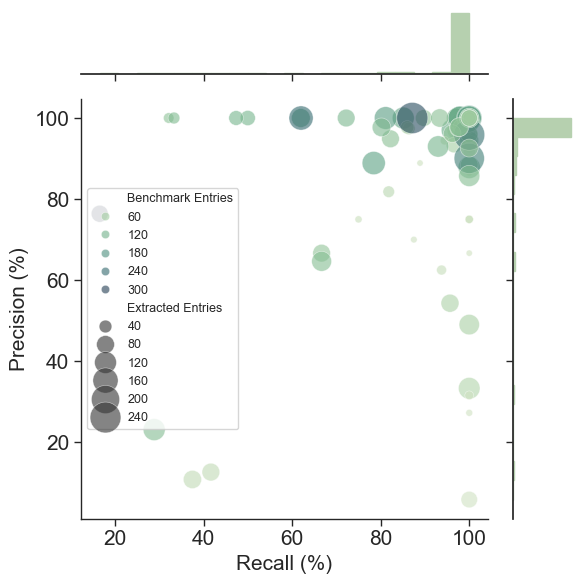

In [129]:
json_path = 'data/single_model/166篇_md_aggregate_一步走_p_1_0806_claude-3-5-sonnet-20240620_128k_stream_max_tokens_8192_temperature_0.1_no_接着说.json'

plot_joint_distribution(json_path, 'total_right_num', 'total_golden', 'total_big_model')


4.0. 展示从annotated 到 entire dataset 推广的 split violin plot 代码

In [200]:
def plot_f1_split_violin(total_df, title=None, xlabel='F1-score', ylabel='Dataset'):
    """
    基于 evaluated on Brenda/Golden * entire/annotated dataset 上的F1 的horizontal split violin plot
    参数：
    total_df (DataFrame): 包含 'F1' ,'eval_on' 和 'dataset' 列的 DataFrame
    """
    # 设置样式
    sns.set(style="ticks")

    # 创建图形
    fig = plt.figure(figsize=(5, 4))

    # violin plot
    sns.violinplot(y='dataset', x='F1', hue='eval_on', data=total_df, alpha=.5, palette='Set1', bw_adjust=.3, split=True, inner='quart',orient='h',gap=0.1)

    # title和labels
    plt.title(title, fontsize=15)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)

    # 设置刻度标签的字体大小
    plt.gca().tick_params(axis='both', labelsize=15)

    # 去掉顶部和右侧边框
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(True)
    plt.gca().spines['bottom'].set_visible(True)

    # 显示图表
    plt.tight_layout()
    plt.show()

    return fig

4.2. Claude模型在entire dataset上的表现

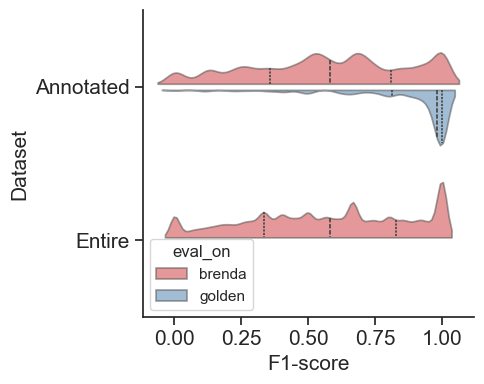

In [201]:
json_path = 'data/entire_dataset_data/3450_brenda.json'
brenda_3435 = calculate_f1_from_json(json_path)
# brenda_3435.to_csv('brenda_3435.csv')  # claude_brenda_3435
json_path = 'data/entire_dataset_data/3450_golden.json'
golden_156 = calculate_f1_from_json(json_path)  # 因为金标准只有156篇，所以这里是156篇的结果
# golden_156.to_csv('golden_156.csv')  # claude_golden_156

# 添加 eval_on 列, 表示结果来自于 和哪个标准进行比较的 结果
brenda_3435['eval_on'] = 'brenda'
golden_156['eval_on'] = 'golden'

# 处理 brenda_3435 数据，添加 dataset 列
brenda_data = brenda_3435[['F1', 'eval_on']].copy()
brenda_data['dataset'] = 'Entire'

# 处理 golden_156 数据，添加 dataset 列
golden_data = golden_156[['F1', 'eval_on']].copy()
golden_data['dataset'] = 'golden'

# 合并 brenda 和 golden 数据
combined_data = pd.concat([brenda_data, golden_data], axis=0)

# 因为是包含关系，找到共有的 pubmedid，实际上就是156的pubmedid
common_pubmedid = brenda_3435.index.intersection(golden_156.index)

# 156的标记为'annotated'，其他的不管继续为'entire'
for index in common_pubmedid:
    combined_data.loc[combined_data.index == index, 'dataset'] = 'Annotated'

# 设置顺序，不然画图的时候entire会画到上面去
combined_data['dataset'] = pd.Categorical(combined_data['dataset'], categories=['Annotated', 'Entire'], ordered=True)
combined_data.reset_index()

#  绘制split_violin plot，来展示从annotated 到 entire dataset 的推广
fig = plot_f1_split_violin(combined_data)

# 存储图
fig.savefig('figure/fig.2e.svg', format='svg', bbox_inches='tight')
fig.savefig('figure/fig.2e.png', format='png', dpi=300, bbox_inches='tight')